# Важен ли пользователям шрифт?

**Описание данных**

Каждая запись в логе — это действие пользователя, или событие.

- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_white"
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
colors =["#ef476f","#ffd166","#06d6a0","#118ab2","#073b4c"]
sns.set_palette(sns.color_palette(colors))
import re
import warnings
warnings.filterwarnings("ignore") 
from scipy import stats as st
import math as mth

In [37]:
try:
    data = pd.read_csv(r'C:/Users/shayb/Downloads/logs_exp.csv', sep = '\t')
except:
    data = pd.read_csv('/datasets/logs_exp.csv', sep = '\t')

In [38]:
display(data.head(5))
data.info()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


На первый взгляд про датафрейм можно сказать следующее:
- в датафрейме 244126 записей;
- названия столбцов не соответствуют общепринятому стилю;
- пропуски отсутствуют.

## Предобработка данных

Приведем названия столбцов в удобный вид.

In [39]:
data.columns = data.columns.str.lower()

In [40]:
data = data.rename(
    columns={
        'eventname': 'event_name',
        'deviceidhash': 'device_id_hash',
        'eventtimestamp': 'event_timestamp',
        'expid': 'exp_id'
    })

In [41]:
def aab_group(gr):
    if gr == 246:
        return 'A1'
    elif gr == 247:
        return 'A2'
    else:
        return 'B'


data['exp_id'] = data['exp_id'].apply(aab_group)
data

,event_name,device_id_hash,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,A1
1,MainScreenAppear,7416695313311560658,1564053102,A1
2,PaymentScreenSuccessful,3518123091307005509,1564054127,B
3,CartScreenAppear,3518123091307005509,1564054127,B
4,PaymentScreenSuccessful,6217807653094995999,1564055322,B
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,A2
244122,MainScreenAppear,5849806612437486590,1565212439,A1
244123,MainScreenAppear,5746969938801999050,1565212483,A1
244124,MainScreenAppear,5746969938801999050,1565212498,A1


Проверим датафрейм на дубликаты.

In [42]:
print(data.duplicated().sum())

413


In [43]:
data = data.drop_duplicates().reset_index(drop=True)

In [44]:
print(data.duplicated().sum())

0


Проверим датафрейм на наличие пропусков.

In [45]:
print(data.isna().sum())

event_name         0
device_id_hash     0
event_timestamp    0
exp_id             0
dtype: int64


Добавим столбец даты и времени, а также отдельный столбец дат. Изменим тип данных столбцов на необходимый.

In [46]:
data['event_datetime'] = pd.to_datetime(data['event_timestamp'], unit='s')
data['event_date'] = data['event_datetime'].astype('datetime64[D]')
data['event_date'] = data['event_date'].dt.date
data['event_month'] = data['event_date'].astype('datetime64[M]')
data.sample(5)

,event_name,device_id_hash,event_timestamp,exp_id,event_datetime,event_date,event_month
171638,CartScreenAppear,2305766456715991733,1565028670,B,2019-08-05 18:11:10,2019-08-05,2019-08-01
137089,OffersScreenAppear,7980064927529100411,1564944790,A2,2019-08-04 18:53:10,2019-08-04,2019-08-01
161780,Tutorial,8697620253425868959,1565015411,B,2019-08-05 14:30:11,2019-08-05,2019-08-01
235565,CartScreenAppear,2144391735501062779,1565194039,B,2019-08-07 16:07:19,2019-08-07,2019-08-01
101999,CartScreenAppear,5858656528858890652,1564853290,A2,2019-08-03 17:28:10,2019-08-03,2019-08-01


In [47]:
print('В логе всего', len(data), 'событий.')

В логе всего 243713 событий.


In [48]:
print('В логе всего', data['device_id_hash'].nunique(), 'пользователей.')

В логе всего 7551 пользователей.


In [49]:
print('В среднем на одного пользователя приходится',
      round(data.groupby('device_id_hash')['event_name'].agg('count').median()),
      'событий.')

В среднем на одного пользователя приходится 20 событий.


In [50]:
print('Мы распологаем данными с', data['event_datetime'].min(), 'по',
      data['event_datetime'].max())

Мы распологаем данными с 2019-07-25 04:43:36 по 2019-08-07 21:15:17


Посмотрим на динамику событий во временном разрезе.

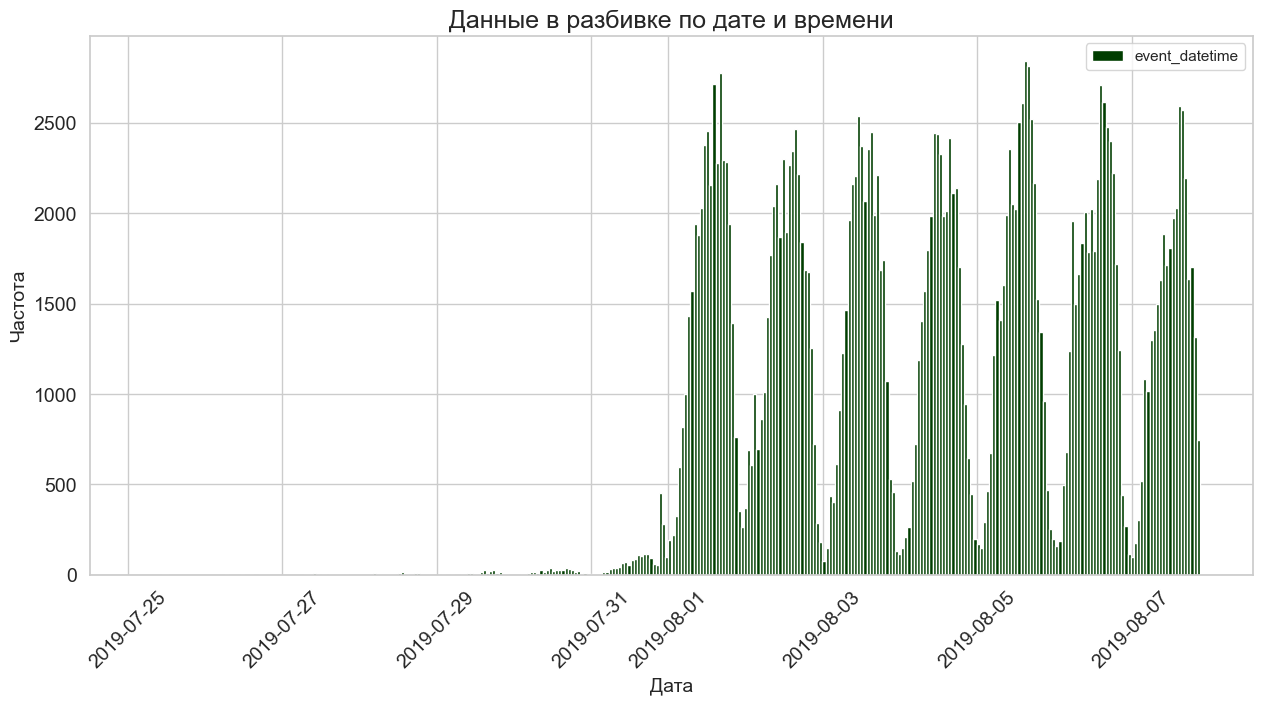

In [51]:
data['event_datetime'].hist(bins=14 * 24,
                            figsize=(15, 7),
                            color='#003d00',
                            legend=True)
plt.title('Данные в разбивке по дате и времени', fontsize=18)
plt.ylabel('Частота', fontsize=14)
plt.tick_params(labelsize=14)
plt.xlabel('Дата', fontsize=14)
plt.xticks(rotation=45)
plt.show()

По графику видно, что примерно до 31 июля событий почти не происходило. Посмотрим на данные в разбивке по времени и по каждому виду событий отдельно.

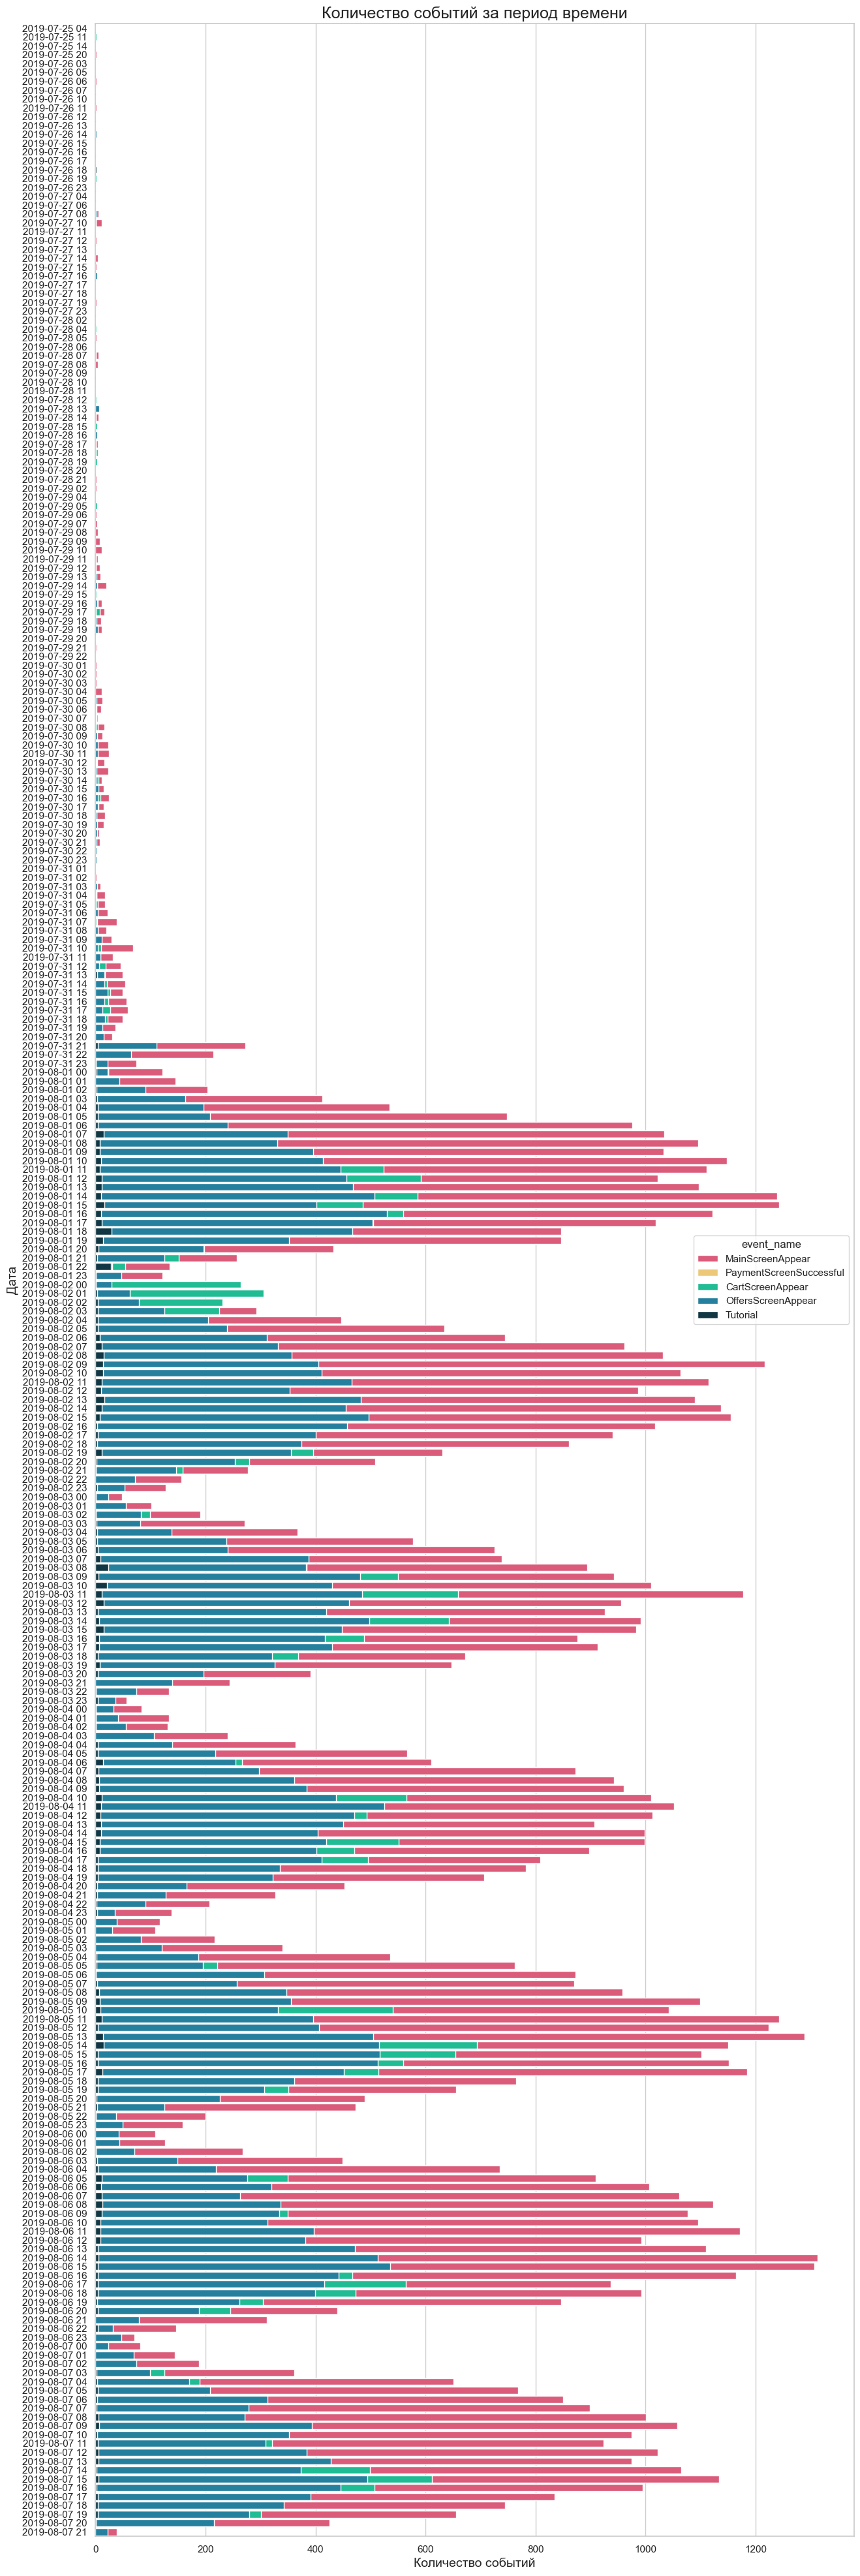

In [52]:
plt.figure(figsize=(15, 50))
ax = sns.countplot(y=data['event_datetime'].dt.strftime('%Y-%m-%d %H'), hue='event_name', data=data, dodge=False)
ax.set_title('Количество событий за период времени', fontsize=18)
plt.ylabel('Дата', fontsize=14)
plt.xlabel('Количество событий', fontsize=14)
plt.show()

Действительно, по графику видно, что до 1 августа действий происходит очень мало. Оставим события, которые происходили с 1 августа, а все остальные удалим. Так мы отбросим "старые" данные и сделаем их более полными.

In [53]:
new_data = data.query('event_month == "2019-08-01"').reset_index(drop=True)

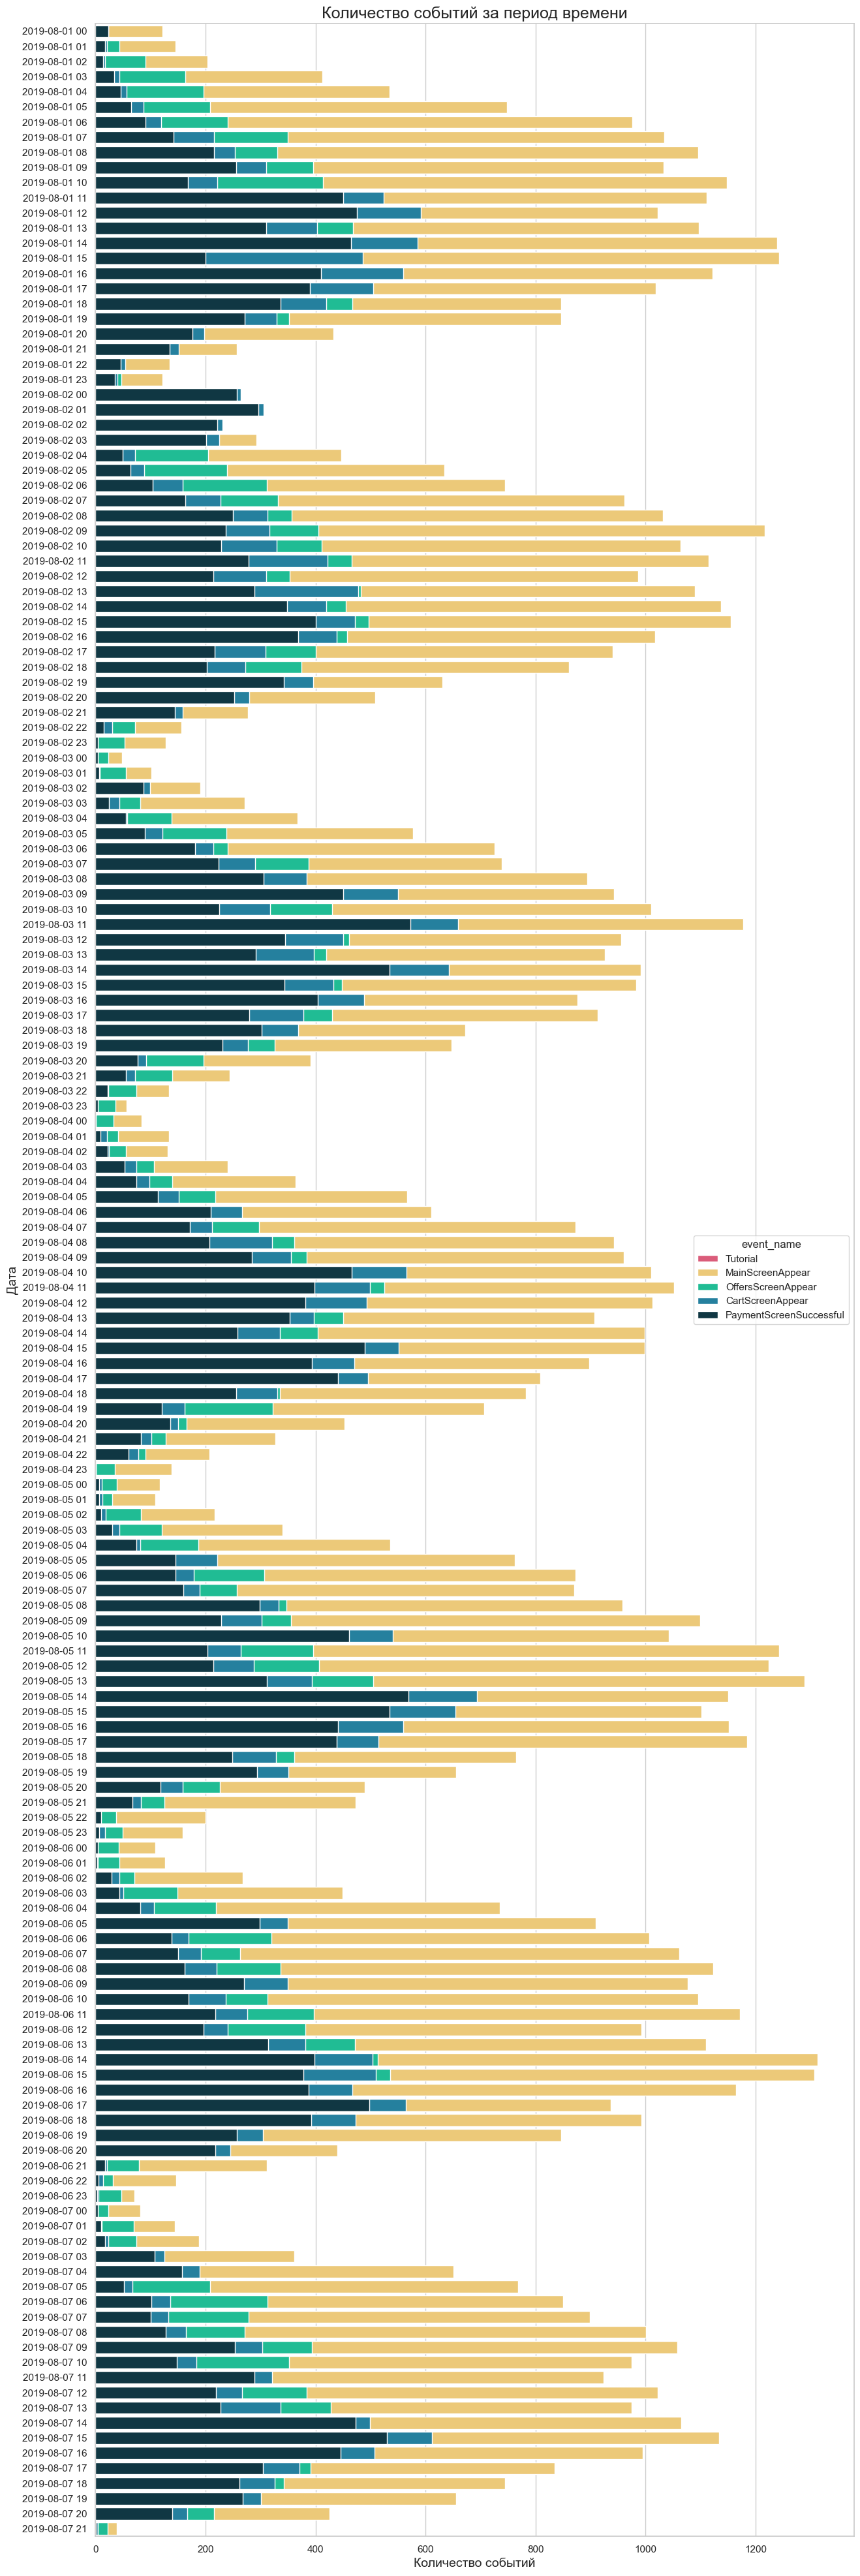

In [54]:
plt.figure(figsize=(15, 50))
ax = sns.countplot(y=new_data['event_datetime'].dt.strftime('%Y-%m-%d %H'),
                   hue='event_name',
                   data=new_data,
                   dodge=False)
ax.set_title('Количество событий за период времени', fontsize=18)
plt.ylabel('Дата', fontsize=14)
plt.xlabel('Количество событий', fontsize=14)
plt.show()
plt.show()

Вот тут мы уже может видеть действия с оплатой и равномерный волнообразный график.

In [55]:
print('Количество событий до отброса данных:', len(data))
print('Количество пользователей до отброса данных:', data['device_id_hash'].nunique())
print('Количество событий после отброса данных:', len(new_data))
print('Количество пользователей после отброса данных:', new_data['device_id_hash'].nunique())
print('В процессе отброса данных мы потеряли следующий процент событий:',
      round((len(data) - len(new_data))/len(data)*100, 2))
print('В процессе отброса данных мы потеряли следующий процент пользователей:',
      round((data['device_id_hash'].nunique() - new_data['device_id_hash'].nunique())/
            data['device_id_hash'].nunique()*100, 2))

Количество событий до отброса данных: 243713
Количество пользователей до отброса данных: 7551
Количество событий после отброса данных: 240887
Количество пользователей после отброса данных: 7534
В процессе отброса данных мы потеряли следующий процент событий: 1.16
В процессе отброса данных мы потеряли следующий процент пользователей: 0.23


В процессе очистки мы потеряли чуть больше одного процента, это совсем не критично и никак не повлияет на анализ данных.

Проверим, есть ли у нас пользователи из всех трёх экспериментальных групп.

In [56]:
display(new_data.groupby('exp_id', as_index=False).agg({'device_id_hash': 'nunique'}))

,exp_id,device_id_hash
0,A1,2484
1,A2,2513
2,B,2537


Да, мы располагаем данными, в которых есть пользователи из всех трёх экспериментальных групп.

**Вывод:** в результате исследовательского анализа данных мы очистили данные и оставили только события, происходящие с 1 августа, потеряв при это чуть больше одного процента данных. Это сделано для того, чтобы временной отрезок подходил под условия нашего эксперимента.

## Воронка событий

Посмотрим, какие события есть в логах, как часто они встречаются.

In [57]:
display(new_data.groupby('event_name',
                     as_index=False).agg({'event_datetime': 'nunique'}).sort_values(by = 'event_datetime',
                                                                                                  ascending=False))

,event_name,event_datetime
1,MainScreenAppear,103628
2,OffersScreenAppear,43985
0,CartScreenAppear,40208
3,PaymentScreenSuccessful,32586
4,Tutorial,1005


- MainScreenAppear - появление главного экрана;
- OffersScreenAppear - появление экрана с продуктами;
- CartScreenAppear - появление экрана с корзиной;
- PaymentScreenSuccessful - появление экрана с подтверждением оплаты;
- Tutorial - появление экрана с обучением.

У нас всего пять возможных событий. Самым частым является посещение главного экрана, а самым редким посещение станицы с обучением.

Посчитаем, сколько пользователей совершали каждое из этих событий и долю пользователей, которые хоть раз совершали событие.

In [58]:
df = new_data.groupby('event_name',
                     as_index=False).agg({'device_id_hash': 'nunique'}).sort_values(by = 'device_id_hash', ascending=False)
df['%'] = round(df['device_id_hash']/new_data['device_id_hash'].nunique() * 100.0, 1)
df 

,event_name,device_id_hash,%
1,MainScreenAppear,7419,98.5
2,OffersScreenAppear,4593,61.0
0,CartScreenAppear,3734,49.6
3,PaymentScreenSuccessful,3539,47.0
4,Tutorial,840,11.1


- Больше всего пользователей посетило главный экран, а меньше всего страницу с обучением.
- 98,5 % пользователей посещали главную страницу сайта хотя бы один раз, а 47 % посетили страницу с оплатой хотя бы один раз.

У нас есть пять событий, можно предположить, что пользователи путешествуют по сайту в следующей последовательности:

MainScreenAppear (появление главного экрана) ==> OffersScreenAppear (появление экрана с продуктами) ==> CartScreenAppear (появление экрана с корзиной) ==>
PaymentScreenSuccessful (появление экрана с подтверждением оплаты)

У нас есть  действие Tutorial (появление экрана с обучением), которое пользователь может открыть в любой момент и расположение которого в цепочке последовательности предположить не возможно.
Страницу Tutorial посещает маленький процент пользователей и ее посещение никак не влияет на то, дойдет ли пользователь до страницы оплаты, поэтому при построении воронки событий мы не будем учитывать это дейсвие.

In [59]:
new_data = new_data.query('event_name != "Tutorial"').reset_index(drop=True)

**Посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитаем отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.**

In [60]:
clean_data = df.query('event_name != "Tutorial"').reset_index(drop=True)
prev_users = clean_data.loc[0,'device_id_hash']
start_data = prev_users

for i in clean_data.index:
    clean_data.loc[i,'next'] = (clean_data.loc[i,'device_id_hash'] / prev_users * 100).round(1)
    clean_data.loc[i,'one'] = (clean_data.loc[i,'device_id_hash'] / start_data * 100).round(1)
    prev_users = clean_data.loc[i,'device_id_hash']
clean_data

,event_name,device_id_hash,%,next,one
0,MainScreenAppear,7419,98.5,100.0,100.0
1,OffersScreenAppear,4593,61.0,61.9,61.9
2,CartScreenAppear,3734,49.6,81.3,50.3
3,PaymentScreenSuccessful,3539,47.0,94.8,47.7


In [61]:
fig = go.Figure(go.Funnel(x = clean_data['one'], y = clean_data['event_name'],
                          textinfo='value + percent initial',
                          marker = {'color':'#003d00'}))
fig.update_layout(title_text=  'Доля пользователей следующего шага относительно первого шага')
fig.show(); 

Данная воронка показывает нам сколько всего пользователей совершило то или иное действие. На страницу с вобором товара переходят всего 62 % пользователей,то есть на втором этапе мы теряем больше всего пользователей - 38 %.

Оплачивает покупки 48 % пользователей.

In [62]:
fig = go.Figure(go.Funnel(x = clean_data['next'], y = clean_data['event_name'],
                          textinfo='value + percent initial',
                          marker = {'color':'#003d00'}))
fig.update_layout(title_text=  'Доля пользователей следующего шага относительно предыдущего шага')
fig.show();

По данной воронке можно сказать сколько процентов пользователей отваливаются относильно предыдущего шага, а не первого. А отваливается вот столько процентов:

100 % ==> 38 % ==> 19 % ==> 5 %

Следовательно больше всего пользователей теряется на шаге просмотра корзины (отваливается 38 %), а вот уже на следующих шагах отваливается мало пользователей, что хорошо.

**Вывод:** в данном разделе мы образовали воронку (предположили последовательность действий пользователей), узнали на каком этапе теряется больше всего пользователей.

### Результаты эксперимента

In [63]:
count_user_group = data.groupby('exp_id')['device_id_hash'].nunique()
count_user_group['A1+A2'] = count_user_group['A1']+count_user_group['A2']
count_user_group

exp_id
A1       2489
A2       2520
B        2542
A1+A2    5009
Name: device_id_hash, dtype: int64

По этой таблице видим сколько пользователей в каждой эксперементальной группе.

Проверим нет ли пользователей, которые принаждежат нескольким группам.

In [64]:
df_new = new_data[['device_id_hash', 'exp_id']]
gr = df_new.groupby('device_id_hash')['exp_id'].nunique().sort_values(ascending = False)
gr

device_id_hash
6888746892508752       1
6204944347213293942    1
6215559225876063378    1
6215162890135937308    1
6213626876710715478    1
                      ..
3171454373076660766    1
3170212200647575044    1
3167974726645136146    1
3167390091686880227    1
9222603179720523844    1
Name: exp_id, Length: 7530, dtype: int64

Каждый пользоатель пренадлежит только одной группе.

**Проверим, находят ли статистические критерии разницу между выборками А1 и А2. Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным.**

Создадим таблицу с необходимыми расчетами для А/А/В-теста.

In [65]:
event_pivot = new_data.pivot_table(index='event_name',
                                   columns='exp_id',
                                   values='device_id_hash',
                                   aggfunc='nunique').sort_values(by='A1',
                                                                  ascending=False).reset_index()

event_pivot['A1+A2'] = event_pivot['A1'] + event_pivot['A2']
event_pivot['A1A2B'] = event_pivot['A1+A2'] + event_pivot['B']

event_pivot['A1_share'] = (event_pivot['A1'] / count_user_group['A1'] * 100).round(1)
event_pivot['A2_share'] = (event_pivot['A2'] / count_user_group['A2'] * 100).round(1)
event_pivot['B_share'] = (event_pivot['B'] / count_user_group['B'] * 100).round(1)
event_pivot['A1+A2_share'] = ((event_pivot['A1'] + event_pivot['A2']) / 
                                  (count_user_group['A1'] + count_user_group['A2']) * 100).round(1)
event_pivot


exp_id,event_name,A1,A2,B,A1+A2,A1A2B,A1_share,A2_share,B_share,A1+A2_share
0,MainScreenAppear,2450,2476,2493,4926,7419,98.4,98.3,98.1,98.3
1,OffersScreenAppear,1542,1520,1531,3062,4593,62.0,60.3,60.2,61.1
2,CartScreenAppear,1266,1238,1230,2504,3734,50.9,49.1,48.4,50.0
3,PaymentScreenSuccessful,1200,1158,1181,2358,3539,48.2,46.0,46.5,47.1


Определим самое популярное событие.

In [66]:
new_data['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Name: event_name, dtype: int64

Самым популярным событием является посещение главной страницы.

Результат успешного А/А-теста - две взятые намыми выборки одинаковы.
Чтобы проверить будет ли выборки одинаковыми проведем z-test. Данный тест нам подходит, потому что у нас большая выборка (> 30).

Сформулируем гипотезы для А1 и А2 выборок:
- H0: выбрки А1 и А2 равны
- H1: выбрки А1 и А2 не равны

Напишем функцию, для проведения теста с каждым событием.

In [67]:
def z_test(group1, group2, alpha):
    for i in event_pivot.index:
        p1 = event_pivot[group1][i] / count_user_group[group1]
        # пропорция успехов во второй группе:
        p2 = event_pivot[group2][i] / count_user_group[group2]
        # пропорция успехов в комбинированном датасете:
        p_combined = ((event_pivot[group1][i] + event_pivot[group2][i]) / 
                      (count_user_group[group1] + count_user_group[group2]))
        # разница пропорций в датасетах
        difference = p1 - p2
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * 
                                        (1/count_user_group[group1] + 1/count_user_group[group2]))
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1) 
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('{} p-значение: {}'.format(event_pivot['event_name'][i], p_value))
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между выборками есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными")
        print('')
        
z_test('A1', 'A2', 0.01)

MainScreenAppear p-значение: 0.6194860229779078
Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными

OffersScreenAppear p-значение: 0.2352227460362717
Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными

CartScreenAppear p-значение: 0.21899829728450415
Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными

PaymentScreenSuccessful p-значение: 0.10914759823712927
Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными



**На имеющихся данных, на уровне значимости 1% нет оснований отвергнуть нулевую гипотезу в пользу альтернативы, поэтому можем предположить, что группы А1 и А2 можно считать равными.**

Проведем z-test с другими выборками: А1/В, А2/В, А1+А2/В.

Сформулируем гипотезы для А1 и В выборок:
- H0: выбрки А1 и В равны
- H1: выбрки А1 и В не равны

In [68]:
z_test('A1', 'B', 0.01)

MainScreenAppear p-значение: 0.32916112087956995
Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными

OffersScreenAppear p-значение: 0.2097513010649208
Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными

CartScreenAppear p-значение: 0.07897406022802644
Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными

PaymentScreenSuccessful p-значение: 0.21318312148591856
Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными



**На имеющихся данных, на уровне значимости 1% нет оснований отвергнуть нулевую гипотезу в пользу альтернативы, поэтому можем предположить, что группы А1 и B можно считать равными.**

Сформулируем гипотезы для А2 и В выборок:
- H0: выбрки А2 и В равны
- H1: выбрки А2 и В не равны

In [69]:
z_test('A2', 'B', 0.01)

MainScreenAppear p-значение: 0.630511483398956
Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными

OffersScreenAppear p-значение: 0.948242051780652
Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными

CartScreenAppear p-значение: 0.598491352466854
Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными

PaymentScreenSuccessful p-значение: 0.7174796792830545
Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными



**На имеющихся данных, на уровне значимости 1% нет оснований отвергнуть нулевую гипотезу в пользу альтернативы, поэтому можем предположить, что группы А2 и B можно считать равными.**

Сформулируем гипотезы для A1+А2 и В выборок:
- H0: выбрки A1+А2 и В равны
- H1: выбрки A1+А2 и В не равны

In [70]:
z_test('A1+A2', 'B', 0.01)

MainScreenAppear p-значение: 0.39650789406907316
Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными

OffersScreenAppear p-значение: 0.44807592847340594
Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными

CartScreenAppear p-значение: 0.18799753938915797
Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными

PaymentScreenSuccessful p-значение: 0.6123472065065059
Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными



**На имеющихся данных, на уровне значимости 1% нет оснований отвергнуть нулевую гипотезу в пользу альтернативы, поэтому можем предположить, что группы A1+А2 и B можно считать равными.**

Таким образом, было 4 проверки статичстических гипотез при уровне значимости 0,1. Данный уровень значимости был выбран для более точных результатов экпериментов и большей чувствиельности к отличиям в выбрках.

## Общий вывод:
В ходе исследования была проделана следующая работа:

- выполнили исследовательский анализ данных, в ходе которого выяснили следующее:
  - очистили данные для качественного исследования и оставили только события, происходящие с 1 августа по 8 августа 2019 года, потеряв при это чуть больше одного процента данных.
- построили и изучили воронку событий:
  - Больше всего пользователей относительно первого шага отваливается уже на втором этапе (43 %), а до этапа оплаты доходят всего 48 % пользователей;
  - больше всего пользователей относительно предыдущего шага теряется на шаге просмотра корзины (отваливается 48 %).
- провели 4 статистических эксперимента (А1/А2, А1/В, А2/В, А1+А2/В):
  - во всех четырех экспериментах на имеющихся данных, на уровне значимости 1% нет оснований отвергнуть нулевую гипотезу в пользу альтернативы, поэтому можем предположить, что группы A1, А2 и B можно считать равными.
   
**Результаты эксперимента:** изменение шрифта в мобильном приложении никак не повлияло на поведение пользователей.

**Рекомендации:** следует обратить внимание на второй этап - переход пользователей с главной страницы к выбору товаров. На этом этапе теряется очень большой процент пользователей (43 %). На следующих этапов отваливается довольно мало пользователей и явных проблем нет. Пользователи со второго этапа в большом проценте доходят до оплаты.